In [1]:
from datetime import date
import pandas as pd
from time import sleep
import numpy as np

rate_lim = 30

def monthly_15ths_desc(start="2025-07-15", end="2020-07-15"):
    y1, m1, d1 = map(int, start.split("-"))
    y0, m0, d0 = map(int, end.split("-"))
    if d1 != 15 or d0 != 15:
        raise ValueError("Start and end must be on the 15th.")
    y, m = y1, m1
    out = []
    while (y > y0) or (y == y0 and m >= m0):
        out.append(f"{y:04d}-{m:02d}-15")
        m -= 1
        if m == 0:
            m = 12
            y -= 1
    return out

dates = monthly_15ths_desc()  # descending list from 2025-07-15 back to 2020-07-15


In [2]:

from tqdm import tqdm
eloList = []
for d in tqdm(dates):
    try:
        url = f'http://api.clubelo.com/{str(d)}'
        dfDate = pd.read_csv(url,index_col=0)
        #dfDate = dfDate[dfDate.Country == 'BEL']
        dfDate = dfDate[dfDate.Level == 1]

    except:
        print(f"failed call for {d}")

    eloList.append(dfDate)
    sleep(60/rate_lim)

allElo = pd.concat(eloList)

100%|██████████| 61/61 [03:01<00:00,  2.98s/it]


In [5]:
import re
import unicodedata
import pandas as pd
from rapidfuzz import fuzz, process

# --- normalization helper ---
_STOPWORDS = {"fc", "cf", "sc", "afc", "cfc", "ac", "bc", "u", "club", "the"}

def _normalize(name: str) -> str:
    s = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("ascii").lower()
    s = re.sub(r"[^a-z0-9&\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    tokens = [t for t in s.split() if t not in _STOPWORDS]
    return " ".join(tokens) or s

def map_top_matches(list1, list2, top_n=3, scorer=fuzz.WRatio, min_score=60):
    """
    Returns a DataFrame where each row is an item from list1
    and up to top_n fuzzy matches from list2.
    """
    # preprocess list2
    choices = [(t2, _normalize(t2)) for t2 in list2]
    choices_norm = [n for _, n in choices]

    rows = []
    for t1 in list1:
        norm_q = _normalize(t1)
        matches = process.extract(norm_q, choices_norm, scorer=scorer, limit=top_n)
        
        row = {"Team": t1}
        for i, (choice_norm, score, pos) in enumerate(matches, start=1):
            score = int(round(score))
            if score < min_score:
                row[f"Match{i}"] = None
                row[f"Score{i}"] = None
            else:
                row[f"Match{i}"] = choices[pos][0]   # original name
                row[f"Score{i}"] = score
        rows.append(row)

    return pd.DataFrame(rows)


In [ ]:
def define_midpoint(late,early):
    mid = early + (late - early) / 2

    return mid




In [63]:
plot_df = allElo[allElo.Level == 1]
plot_df = allElo[['Elo','Country']].groupby('Country').mean().sort_values(by='Elo',ascending=False).sort_values(by='Elo',ascending=True).reset_index()


condition = ['POR','BEL','NED','AUT','SUI','DEN']

plot_df['color'] = plot_df['Country'].map(
    lambda x: colorDict['RGB']['fluoyellow'] if x in condition else colorDict['RGB']['darkblue']
)

plot_df['avg_elo'] = plot_df['Country'] + ' (' + np.round(plot_df['Elo'],0).astype(int).astype(str) + ')'

Text(0.3, 0.001, 'Data from clubelo.com, focus on first tier of every country.')

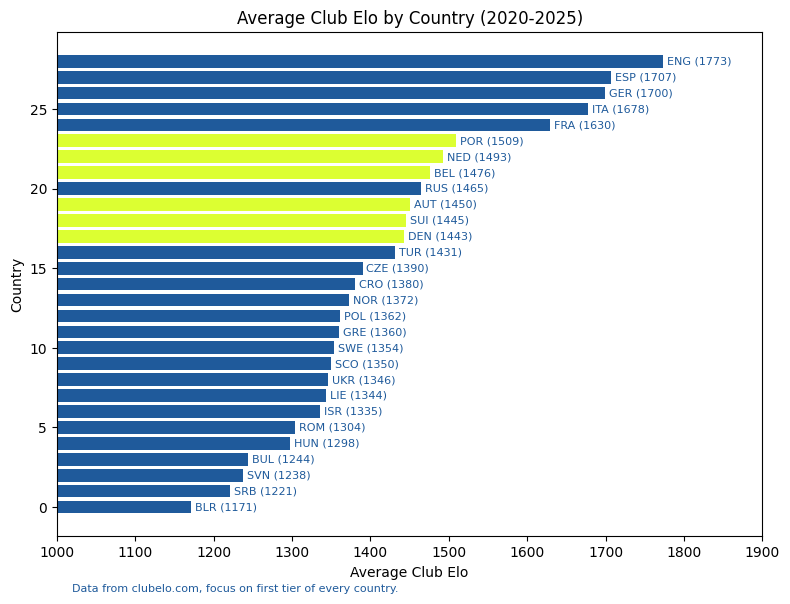

In [64]:
## deciding which competitions to focus on:Thes
from gent_colors import colorDict
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8,6))
ax.barh(plot_df.index,plot_df['Elo'],color=plot_df['color'],alpha=0.9)
ax.set_title('Average Club Elo by Country (2020-2025)')
ax.set_xlabel('Average Club Elo')
ax.set_ylabel('Country')
ax.set_xlim(1000,1900)

for i in range(len(plot_df)):
    ax.text(plot_df['Elo'].iloc[i]+5, i, plot_df['avg_elo'].iloc[i], va='center', ha='left', fontsize=8, color=colorDict['RGB']['darkblue'], alpha=0.9)
plt.tight_layout()

fig.text(0.3, 0.001, 'Data from clubelo.com, focus on first tier of every country.', 
         ha='center', va='bottom', fontsize=8, color=colorDict['RGB']['darkblue'], alpha=0.9)


In [65]:
keep_df = plot_df[plot_df['Country'].isin(condition)].sort_values(by='Elo',ascending=False).reset_index(drop=True)

In [101]:
elo_teams = allElo[(allElo.Level == 1) & (allElo.Country.isin(condition))]
elo_teams['From'] = pd.to_datetime(elo_teams['From'])
elo_teams['To'] = pd.to_datetime(elo_teams['To'])
elo_teams['Date_ref'] = define_midpoint(elo_teams['To'], elo_teams['From'])


elo_teams.to_csv('datasets/Elo_teams.csv',index=False,sep=',')


/var/folders/gr/grh3033930d1vhxcd4gdjy6m0000gn/T/ipykernel_6152/3491482073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elo_teams['From'] = pd.to_datetime(elo_teams['From'])
/var/folders/gr/grh3033930d1vhxcd4gdjy6m0000gn/T/ipykernel_6152/3491482073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elo_teams['To'] = pd.to_datetime(elo_teams['To'])
/var/folders/gr/grh3033930d1vhxcd4gdjy6m0000gn/T/ipykernel_6152/3491482073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [102]:
team_names_elo = elo_teams['Club'].unique().tolist()
team_names_sb = pd.read_csv('datasets/gamedata/SeasonStats.csv',sep=';')['team_name'].unique().tolist()

map_top_matches(team_names_elo,team_names_sb,top_n=3,min_score=70).to_excel('datasets/elo_to_sb_team_map.xlsx',index=False)

/var/folders/gr/grh3033930d1vhxcd4gdjy6m0000gn/T/ipykernel_6152/789747816.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  team_names_sb = pd.read_csv('datasets/gamedata/SeasonStats.csv',sep=';')['team_name'].unique().tolist()


In [103]:
## read mapping dataframe after manual adjustments:
elo_to_sb_map = pd.read_excel('datasets/elo_to_sb_team_map.xlsx')
elo_teams = elo_teams.merge(elo_to_sb_map, left_on='Club', right_on='Team', how='left')


In [105]:
elo_teams[['Club','Country','Level','Elo','Date_ref','Match1']].to_csv('datasets/Elo_teams_mapped.csv',index=False,sep=',')